In [1]:
%matplotlib notebook
import requests
import pandas as pd
import numpy as np
import sklearn.linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

/home/kolesnik/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
START_DATE = "20131010"
END_DATE = "20161012"
WINDOW_SIZE = 7
TOPIC = "Cat"
URL_TEMPLATE = ("https://wikimedia.org/api/rest_v1"  
    "/metrics/pageviews/per-article"
    "/en.wikipedia/all-access/"
    "all-agents/{}/daily/{}/{}")

In [3]:
def get_time_series(topic, start, end):
    url = URL_TEMPLATE.format(topic, start, end)
    response = requests.get(url)
    data = response.json()
    times = [rec['timestamp'] for rec in data['items']]
    values = [rec['views'] for rec in data['items']]
    times_formatted = pd.Series(times).map(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])
    time_index = times_formatted.astype('datetime64[ns]')
    return pd.DataFrame({'views': values}, index=time_index)

def line_slope(ss):
    X=np.arange(len(ss)).reshape((len(ss),1))
    linear.fit(X, ss)
    return linear.coef_

<IPython.core.display.Javascript object>


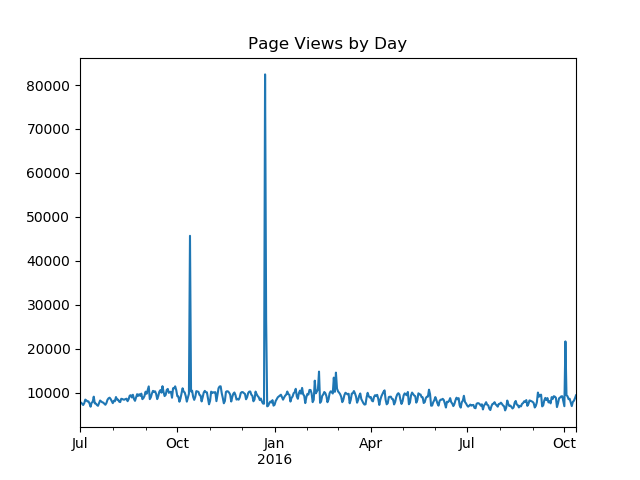

<IPython.core.display.Javascript object>


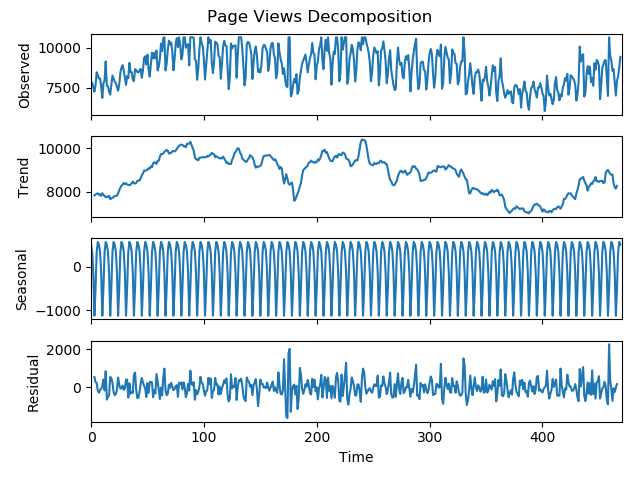

Corr on test data: 0.829620897915


In [4]:
# LinearRegression object will be re-used several times
linear = sklearn.linear_model.LinearRegression()

df = get_time_series(TOPIC, START_DATE, END_DATE)

# Visualize the raw time series
df['views'].plot()
plt.title("Page Views by Day")

# Blunt-force way to remove outliers
max_views = df['views'].quantile(0.95)
df.views[df.views > max_views] = max_views

# Visualize decomposition
decomp = sm.tsa.seasonal_decompose(df['views'].values, freq=7)
decomp.plot()
plt.suptitle("Page Views Decomposition")
plt.subplots_adjust(top=0.93) # Adjust suptitle.

# For each day, add features from previous week
df['mean_1week'] = df['views'].rolling(window=WINDOW_SIZE, center=False).mean()
df['max_1week'] = df['views'].rolling(window=WINDOW_SIZE, center=False).max()
df['min_1week'] = df['views'].rolling(window=WINDOW_SIZE, center=False).min()
df['slope'] = df['views'].rolling(window=WINDOW_SIZE, center=False).apply(line_slope)
df['total_views_week'] = df['views'].rolling(window=WINDOW_SIZE, center=False).sum()
df['day_of_week'] = df.index.astype(int) % 7
day_of_week_cols = pd.get_dummies(df['day_of_week'])
df = pd.concat([df, day_of_week_cols], axis=1)

# Make target variable that we want to predict: views NEXT week.
# Must pad w NANs so dates line up
df['total_views_next_week'] = list(df['total_views_week'][WINDOW_SIZE:]) + [np.nan for _ in range(WINDOW_SIZE)]

INDEP_VARS = ['mean_1week', 'max_1week', 'min_1week', 'slope'] + list(range(6))
DEP_VAR = 'total_views_next_week'

n_records = df.dropna().shape[0]
test_data = df.dropna()[:int(n_records/2)]
train_data = df.dropna()[int(n_records/2):]

linear.fit(
    train_data[INDEP_VARS], train_data[DEP_VAR])

test_preds_array = linear.predict(test_data[INDEP_VARS])
test_preds = pd.Series(test_preds_array, index=test_data.index)
print("Corr on test data:", test_data[DEP_VAR].corr(test_preds))